# Importing Relevant Libraries

In [2]:
import numpy as np
from numpy.random import default_rng

from gpcam import GPOptimizer

import matplotlib.pyplot as plt
import plotly.graph_objects as go
plt.rcParams['font.family'] = 'Arial'

import os
import csv

from scipy.stats import entropy

import random

import torch
from torch import nn


# Loading the Data

In [3]:
energy_data_total = np.load("/data/Dataset 1/energy.npy")
cycle_number_total = np.load("/data/Dataset 1/cycle.npy")


# use slicing to select every other column and all rows
energy_data = energy_data_total[:, ::2]
cycle_number = cycle_number_total[::2]

num_of_datasets = len(energy_data[:,0])

label_size = 30
plt.figure(figsize = (20,10))
for i in range(len(energy_data)): plt.scatter(cycle_number,energy_data[i]) 

plt.tick_params(axis='both', which='major', labelsize=label_size) # Set the font size of the tick labels on the x and y axes
plt.xlabel("Cycle Number",fontsize=label_size) 
plt.ylabel("Energy",fontsize=label_size)
plt.show()


# Creating the cycle_data array with the same shape of energy_data, where all rows have the same values as cycle_number_range. This results in 1 row repeated 22 times.
#cycle_data = np.full_like(energy_data, cycle_number_range)

print("max y: ", np.max(energy_data))

max y:  363.5404228825251


# Creating the Subfolder in Results

In [ ]:
# Specify the path for the new folder
new_folder_path = f"/results/Dataset 1 Figures/Probability of Failure/"

# Create the folder
os.makedirs(new_folder_path, exist_ok=True)


# Deep Kernel Learning

In [5]:
# All remaining code asssumes that the NN architecture is made up of two hidden layers and same number of nodes
# If other architectures are used, the indices of the hyperparameters and their boudsn need to be changed accordingly
# Number of nodes can be varied as the user prefer

class Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.nodes_num = 5

        # Inputs to hidden layer linear transformation
        self.layer1 = nn.Linear(1, self.nodes_num)
        self.layer2 = nn.Linear(self.nodes_num, self.nodes_num)
        self.layer3 = nn.Linear(self.nodes_num, 1)

    def forward(self, x):
        # Pass the input tensor through each of our operations
        #print(x)
        x = torch.Tensor(x)
        x = torch.nn.functional.relu(self.layer1(x))
        x = torch.nn.functional.relu(self.layer2(x))
        x = torch.nn.functional.relu(self.layer3(x))
        return x.detach().numpy()

    def set_weights(self,w1,w2,w3):
      with torch.no_grad():
        self.layer1.weight = nn.Parameter(torch.from_numpy(w1).float())
        self.layer2.weight = nn.Parameter(torch.from_numpy(w2).float())
        self.layer3.weight = nn.Parameter(torch.from_numpy(w3).float())

    def set_biases(self,b1,b2,b3):
      with torch.no_grad():
        self.layer1.bias = nn.Parameter(torch.from_numpy(b1).float())
        self.layer2.bias = nn.Parameter(torch.from_numpy(b2).float())
        self.layer3.bias = nn.Parameter(torch.from_numpy(b3).float())

    def get_weights(self):
        return self.layer1.weight, self.layer2.weight, self.layer3.weight
    def get_biases(self):
        return self.layer1.bias, self.layer2.bias, self.layer3.bias

n = Network()


# Defining the GP Components

In [6]:
# For the squared Exponential Function
def get_distance_matrix(x1,x2):
    d = np.zeros((len(x1),len(x2)))
    for i in range(x1.shape[1]):
        d += (x1[:,i].reshape(-1, 1) - x2[:,i])**2
    return np.sqrt(d)

def my_noise(x,hps,obj):

    total_num_of_NN_hps = obj.args[1]

    my_slope     = hps[total_num_of_NN_hps+1]
    my_pow       = hps[total_num_of_NN_hps+2]
    my_intercept = hps[total_num_of_NN_hps+3]

    my_s = my_slope * x**my_pow + my_intercept
    noise = np.diag(my_s[:,0])
    
    return noise

# Kernel Function
def kernel_nn(x1,x2,hps,obj):

    nodes_num           = obj.args[0]
    total_num_of_NN_hps = obj.args[1]

    trained_NN_hps      = obj.args[3:][0]
    
    # NN
    n.set_weights(trained_NN_hps[0:nodes_num].reshape(nodes_num,1),
                  trained_NN_hps[nodes_num:nodes_num**2+nodes_num].reshape(nodes_num,nodes_num),
                  trained_NN_hps[nodes_num**2+nodes_num:nodes_num**2+2*nodes_num].reshape(1,nodes_num))

    n.set_biases(trained_NN_hps[nodes_num**2+2*nodes_num:nodes_num**2+3*nodes_num].reshape(nodes_num),
                 trained_NN_hps[nodes_num**2+3*nodes_num:nodes_num**2+4*nodes_num].reshape(nodes_num),
                 np.array([trained_NN_hps[nodes_num**2+4*nodes_num]]))

    x1_nn = n.forward(x1).reshape(-1,1)
    x2_nn = n.forward(x2).reshape(-1,1)
    d = get_distance_matrix(x1_nn,x2_nn)


    # Main Function
    k = hps[total_num_of_NN_hps] * obj.squared_exponential_kernel(d, 50) #100

    return k


################################################################################

# Mean function: Two-Element piecewise function
def mean2(x,hps,obj):

    total_num_of_NN_hps = obj.args[1]

    x0 = hps[total_num_of_NN_hps+4]
    
    m1 = hps[total_num_of_NN_hps+5]
    m2 = hps[total_num_of_NN_hps+6]

    b1  = obj.args[2]
    b2 = (m1 - m2) * x0 + b1

    x = x[:,0]

    y = np.where(x <= x0, m1*x + b1, m2*x + b2)
                
    return y

# Creating Distribution

In [7]:
def make_distribution(m,v,x_pred):
    distr = np.zeros((len(x_pred),1000))
    y = np.linspace(0,363,1000)
    std = np.sqrt(v)
    for i in range(len(x_pred)):
        distr[i] = 1./(std[i] * np.sqrt(2 * np.pi)) * np.exp( - (y - m[i])**2 / (2. * std[i]**2))
    return distr

# Finding Ground Truth Probability of Failure

In [8]:
data_size = 20

x_data_all = np.tile(cycle_number, data_size).reshape(-1, 1)   # repeat cycle 20 times to create x_data
y_data_all = np.vstack(energy_data[0:20,:]).reshape(-1, 1)                  # stack energy rows to create y_data


nodes_num = n.nodes_num

total_num_of_NN_hps = 0 # nodes_num**2 + 4*nodes_num + 1     # Depends on the number of layers used
num_of_other_hps = 7                                     # Depends on Kernel, noise and mean functions


init_hyperparameters = np.array([1500,              # Kernel
                           0.06, 2, 2,             # Noise  
                           250,-0.01,-0.015])      # Mean.


# Trained NN hyperparameters
#     These hyperparameters were trained a priori to lower the computational requirements during the battery testing sequence
#     The user has the choice to train these NN hyperparameters with those of the Kernel, Noise, and mean functions
NN_weights_trained_hps = np.array([0.157, 0.149, 0.029, 0.061, 0.016, 0.219, 0.436, 0.148, 0.461, 1.772, 1.945, 0.084,
                                   1.743, 0.731, 1.881, 1.342, 1.015, 0.982, 1.795, 0.4,   1.062, 0.753, 1.052, 1.252,
                                   1.557, 0.708, 0.149, 1.348, 1.481, 0.568, 0.028, 0.036, 0.107, 0.05,  0.101])

NN_biases_trained_hps = np.array([1.168, 1.915, 0.184, 0.145, 0.893, 0.377, 1.289, 0.911, 1.971, 0.339, 1.573])

my_trained_NN_hps = np.concatenate([NN_weights_trained_hps,NN_biases_trained_hps])


In [9]:
dx = 1000./1000.
  
# Setting the Optimization Bounds for Hyperparameters
bounds = np.empty((total_num_of_NN_hps + num_of_other_hps,2))

# Kernel Sq Exp 
bounds[total_num_of_NN_hps] = np.array([500.,7000.])                             # Kernel Variance
#bounds[total_num_of_NN_hps+7] = np.array([10.,300.])                           # Kernel Lengthscale

# Noise
bounds[total_num_of_NN_hps+1] = np.array([1e-5,15.])                           # Noise Slope
bounds[total_num_of_NN_hps+2] = np.array([1,5.])                            # Noise Power
bounds[total_num_of_NN_hps+3] = np.array([0.,5.])                              # Noise Intercept
# Mean
bounds[total_num_of_NN_hps+4] = np.array([200.,450.])                          # Mean Piecewise Intersection point
bounds[total_num_of_NN_hps+5] = np.array([-1e-1,-1e-3])                        # Mean Slope 1
bounds[total_num_of_NN_hps+6] = np.array([-1e-1,-1e-2])                        # Mean Slope 2


trained_hps = np.array([ 3.69988606e+03,  1.00111228e-05,  2.96700098e+00,  2.25831837e+00,
  2.04048171e+02, -2.78484076e-02, -9.82988265e-02])


    
# Finding the mean of the initial capacity to be entered to the code
my_ind = np.where(x_data_all<=10)
initial_capacity = np.mean(y_data_all[my_ind[0]])
    
my_gpGT = GPOptimizer(x_data_all,y_data_all,
            init_hyperparameters = trained_hps,  # we need enough of those for kernel, noise and prior mean functions
            #noise_variances=np.ones(y_data.shape) * 0.01, #provding noise variances and a noise function will raise a warning 
            compute_device='cpu', 
            gp_kernel_function=kernel_nn, 
            gp_kernel_function_grad=None, 
            gp_mean_function=mean2, 
            gp_mean_function_grad=None,
            gp_noise_function=my_noise,
            normalize_y=False,
            sparse_mode=False,
            gp2Scale = False,
            store_inv=False, 
            ram_economy=False, 
            args=np.array([nodes_num,total_num_of_NN_hps,initial_capacity,my_trained_NN_hps]))

 
#my_gpGT.train(hyperparameter_bounds=bounds, method='global')

my_GT_hps = my_gpGT.hyperparameters

print("GT Training Done!")

GT Training Done!


/tmp/ipykernel_5436/2514860958.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args=np.array([nodes_num,total_num_of_NN_hps,initial_capacity,my_trained_NN_hps]))


In [10]:
print("GT Hyperparameters: ", my_gpGT.hyperparameters)

x_pred = np.linspace(0,600,1001).reshape(-1,1)

f_GT = my_gpGT.posterior_mean(x_pred.reshape(-1,1))["f(x)"]
v_GT = my_gpGT.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]


# Plotting the data
plt.figure(figsize = (15,10))
plt.plot(x_pred[:,0],f_GT, color = "red", linewidth = 3,label='Fitted Model')
plt.fill_between(x_pred[:,0],f_GT - 2. * np.sqrt(v_GT), f_GT + 2. * np.sqrt(v_GT), alpha = 0.5, color = "grey", label='Confidence Interval')
plt.scatter(x_data_all,y_data_all, color = "blue",s = 250, label='Data Points') # Training Data
plt.xlabel("Cycle Number",fontsize=label_size) 
plt.ylabel("Energy",fontsize=label_size)
plt.ylim(150,370)
plt.yticks([150, 200, 250, 300, 350])
plt.xlim(0,600)
plt.xticks([0,150,300,450,600])
plt.legend(fontsize=label_size,frameon=False,loc='lower left')
plt.tick_params(axis='both', which='major', labelsize=label_size) # Set the font size of the tick labels on the x and y axes
plt.show()

GT Hyperparameters:  [ 3.69988606e+03  1.00111228e-05  2.96700098e+00  2.25831837e+00
  2.04048171e+02 -2.78484076e-02 -9.82988265e-02]


In [11]:

d_GT = make_distribution(f_GT,v_GT,x_pred)[:,800].T
d_GT = d_GT/(np.sum(d_GT) * dx)

# Number cycles where 5% of batteries failed 
cum_distr = np.cumsum(d_GT)*dx
index_95failed_GT = np.argmin(abs(cum_distr - 0.05))
print("95 percent failed after: ", x_pred[index_95failed_GT,0])
  
epsilon_for_failure_distribution = 1e-10
d_GT = np.maximum(d_GT, epsilon_for_failure_distribution)
    

x_pred1 = np.append(x_pred,np.array([600.1,700]))
d_GT1 = np.append(d_GT,np.array([1e-10,1e-10]))


plt.figure(figsize = (10,10))
plt.plot(x_pred1, d_GT1,linewidth = 5,color = 'black')
plt.xlabel(" ",fontsize=label_size)
plt.ylabel(" ",fontsize=label_size)
#plt.axvline(x=x_pred[index_95failed,0], color='red', linestyle='--',linewidth = 5)
plt.tick_params(axis='both', which='major', labelsize=label_size) # Set the font size of the tick labels on the x and y axes
plt.fill_between(x_pred1, d_GT1, where=(x_pred1 <= x_pred[index_95failed_GT, 0]),interpolate=True, color='red', alpha=0.3)
plt.yticks([])
plt.xlim([250,650])
plt.xticks([])
# Remove the borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.savefig('/results/Dataset 1 Figures/Probability of Failure/POF_my_plot_GroundTruth.pdf', bbox_inches='tight')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


95 percent failed after:  324.59999999999997


# __________________________________________________________________
# Getting the results of Saved Run

In [12]:
energy_data = np.load("/results/Dataset 1 Figures/With Stopping/Training_Y_data.npy")
cycle_number = np.load("/results/Dataset 1 Figures/With Stopping/Training_X_data.npy")


label_size = 30
plt.figure(figsize = (20,10))
plt.scatter(cycle_number,energy_data) 

plt.tick_params(axis='both', which='major', labelsize=label_size) # Set the font size of the tick labels on the x and y axes
plt.xlabel("Cycle Number",fontsize=label_size) 
plt.ylabel("Energy",fontsize=label_size)
plt.show()

print(cycle_number.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/results/Dataset 1 Figures/With Stopping/Training_Y_data.npy'

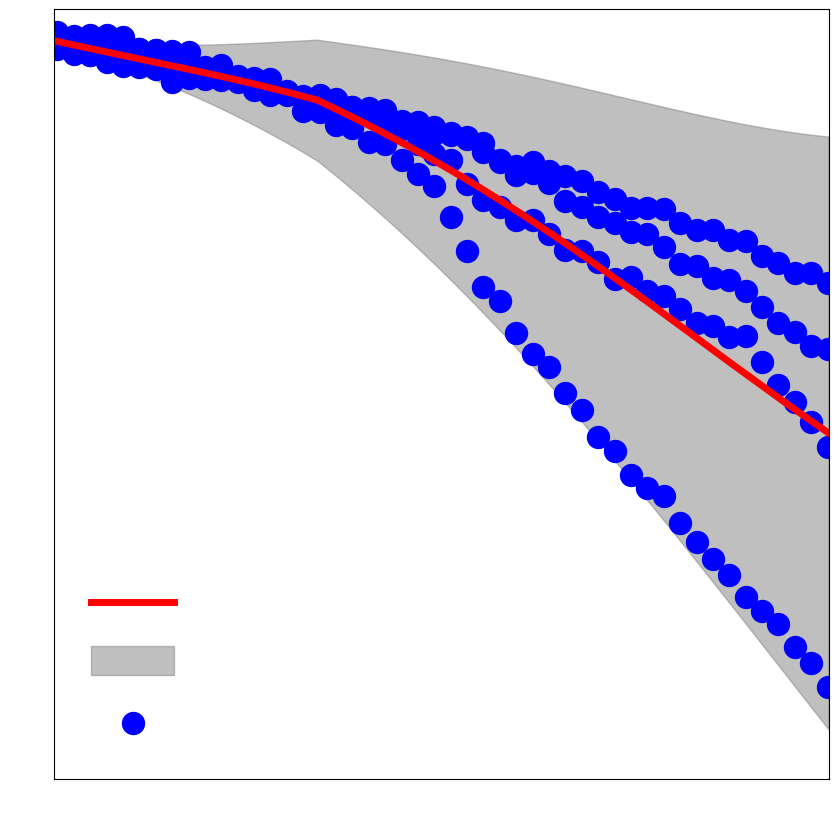

In [20]:
my_trained_hps = np.array([ 3.69988606e+03,  1.00111228e-05,  2.96700098e+00,  2.25831837e+00,
  2.04048171e+02, -2.78484076e-02, -9.82988265e-02])

my_gp = GPOptimizer(cycle_number,energy_data,
            init_hyperparameters = my_trained_hps,  # we need enough of those for kernel, noise and prior mean functions
            #noise_variances=np.ones(y_data.shape) * 0.01, #provding noise variances and a noise function will raise a warning 
            compute_device='cpu', 
            gp_kernel_function=kernel_nn, 
            gp_kernel_function_grad=None, 
            gp_mean_function=mean2, 
            gp_mean_function_grad=None,
            gp_noise_function=my_noise,
            normalize_y=False,
            sparse_mode=False,
            gp2Scale = False,
            store_inv=False, 
            ram_economy=False, 
            args=np.array([nodes_num,total_num_of_NN_hps,initial_capacity,my_trained_NN_hps]))

#my_gp.train(bounds, method='global')


f = my_gp.posterior_mean(x_pred.reshape(-1,1))["f(x)"]
v = my_gp.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]


# Plotting the data
plt.figure(figsize = (10,10))
plt.plot(x_pred[:,0],f, color = "red", linewidth = 5,label=' ')
plt.fill_between(x_pred[:,0],f - 2. * np.sqrt(v), f + 2. * np.sqrt(v), alpha = 0.5, color = "grey", label=' ')
plt.scatter(cycle_number,energy_data, color = "blue",s = 250, label=' ') # Training Data
plt.xlabel(" ",fontsize=label_size) 
plt.ylabel(" ",fontsize=label_size)
plt.ylim(150,370)
#plt.yticks([150, 200, 250, 300, 350])
plt.yticks([ ])
plt.xlim(0,600)
#plt.xticks([0,150,300,450,600])
plt.xticks([ ])
plt.legend(fontsize=label_size,frameon=False,loc='lower left')
plt.tick_params(axis='both', which='major', labelsize=label_size) # Set the font size of the tick labels on the x and y axes
#plt.show()
plt.savefig('/results/Dataset 1 Figures/Probability of Failure/Threshold_Final_GP_Fit.pdf', bbox_inches='tight')

95 percent failed after:  333.0


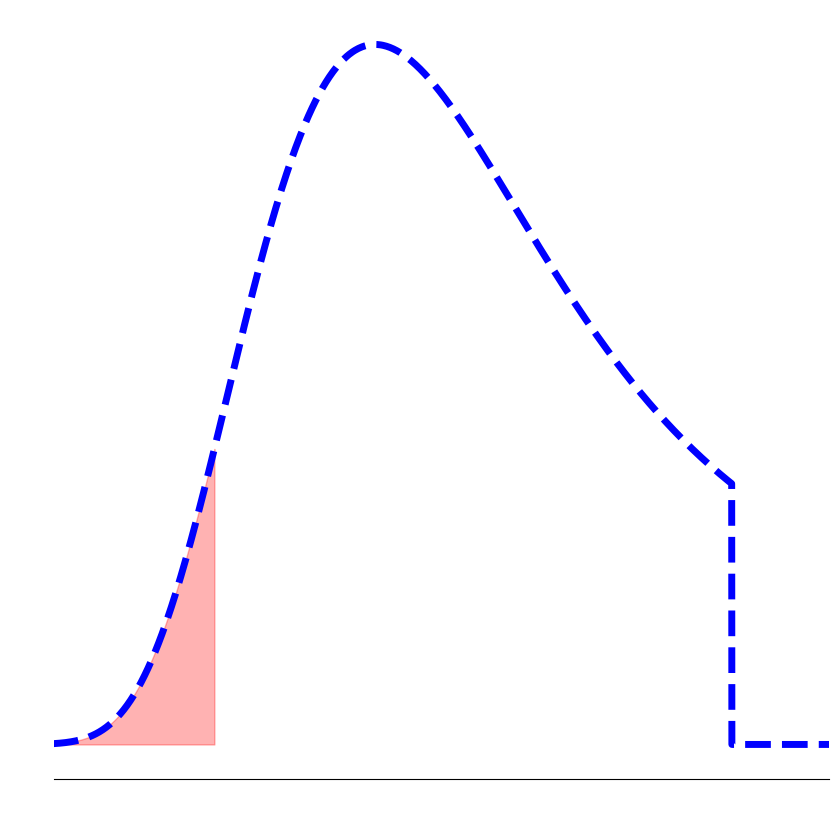

In [22]:
d = make_distribution(f,v,x_pred)[:,800].T

d = d/(np.sum(d) * dx)

# Number cycles where 5% of batteries failed 
cum_distr = np.cumsum(d)*dx
index_95failed_stopped = np.argmin(abs(cum_distr - 0.05))
print("95 percent failed after: ", x_pred[index_95failed_stopped,0])
  
epsilon_for_failure_distribution = 1e-10
d = np.maximum(d, epsilon_for_failure_distribution)
    

x_pred1 = np.append(x_pred,np.array([600.1,700]))
d1 = np.append(d,np.array([1e-10,1e-10]))


plt.figure(figsize = (10,10))
#plt.plot(x_pred1, d_GT1,linewidth = 5,color = 'black',label = "No Stop")
plt.plot(x_pred1, d1,linewidth = 5,color = 'blue', label = "Stop",linestyle='--')

plt.xlabel(" ",fontsize=label_size)
plt.ylabel(" ",fontsize=label_size)
#plt.axvline(x=x_pred[index_95failed,0], color='red', linestyle='--',linewidth = 5)
plt.tick_params(axis='both', which='major', labelsize=label_size) # Set the font size of the tick labels on the x and y axes

plt.fill_between(x_pred1, d1, where=(x_pred1 <= x_pred[index_95failed_stopped, 0]),interpolate=True, color='red', alpha=0.3,label = "5% Fail")
plt.yticks([])
plt.xlim([250,650])
plt.xticks([])
#plt.legend(fontsize=label_size-4,frameon=False,loc='upper right')
# Remove the borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.savefig('/results/Dataset 1 Figures/Probability of Failure/POF_my_plot_StoppedCase.pdf', bbox_inches='tight')

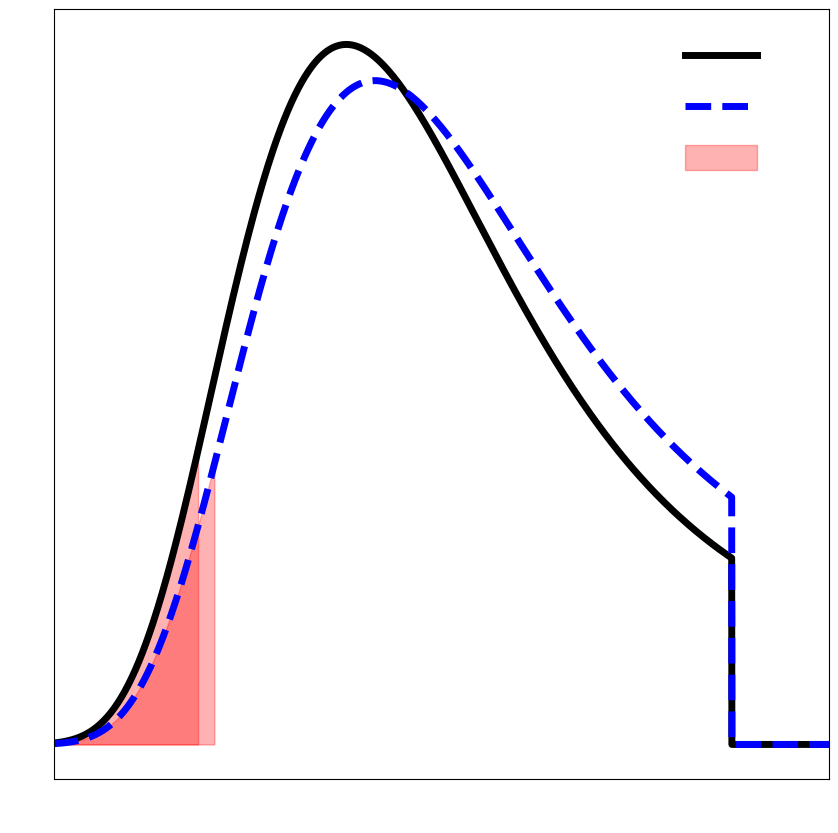

In [23]:
plt.figure(figsize = (10,10))
plt.plot(x_pred1, d_GT1,linewidth = 5,color = 'black',label = " ")
plt.plot(x_pred1, d1,linewidth = 5,color = 'blue',linestyle='--', label = " ")

plt.xlabel(" ",fontsize=label_size)
plt.ylabel(" ",fontsize=label_size)
#plt.axvline(x=x_pred[index_95failed,0], color='red', linestyle='--',linewidth = 5)
plt.tick_params(axis='both', which='major', labelsize=label_size) # Set the font size of the tick labels on the x and y axes
plt.fill_between(x_pred1, d_GT1, where=(x_pred1 <= x_pred[index_95failed_GT, 0]),interpolate=True, color='red', alpha=0.3,label = " ")
plt.fill_between(x_pred1, d1, where=(x_pred1 <= x_pred[index_95failed_stopped, 0]),interpolate=True, color='red', alpha=0.3)

plt.yticks([])
plt.xlim([250,650])
plt.xticks([ ])
plt.legend(fontsize=label_size-4,frameon=False,loc='upper right')
plt.savefig('/results/Dataset 1 Figures/Probability of Failure/POF_my_plot_Both.pdf', bbox_inches='tight')

In [ ]:
# The error is now 2.5%, 72% saving experiments